In [1]:
import sys
import time
import random
from math import *
import operator
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 10000)
import string
from pprint import pprint
from scipy import stats
import itertools
from collections import Counter


# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib import style
%matplotlib inline 

import graphviz 
from sklearn.tree import export_graphviz

# datasets
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.datasets import load_svmlight_files

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load libraries
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# import libraries for model validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import log_loss

from sklearn.model_selection import validation_curve
from scipy.sparse import vstack

In [2]:
print(sys.version)
print('Numpy : ', np.version.version)
print('Scikit learn : ', sklearn.__version__)
print('XGBoost : ', xgb.__version__)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
Numpy :  1.17.2
Scikit learn :  0.20.3
XGBoost :  0.90


# Practice - (decision tree, Adaboost, GBT)

In [3]:
# reproducibility
seed = 104

### Prepare data

In [4]:
# use make_classification to build synthetic data
X, y = make_classification(n_samples=1000, 
                           n_features=20, 
                           n_informative=8, 
                           n_redundant=3, 
                           n_repeated=2, 
                           random_state=seed)

In [5]:
# train -test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [6]:
print("Train label distribution:")
print(Counter(y_train))

print("\nTest label distribution:")
print(Counter(y_test))

Train label distribution:
Counter({1: 404, 0: 396})

Test label distribution:
Counter({0: 106, 1: 94})


Target variable is equally distribued across both dataset.

### Single Decision Tree 
The following code will create a single decision tree, fit it using training data and evaluate the results using test sample.


In [7]:
decision_tree = DecisionTreeClassifier(random_state=seed)

# train classifier
decision_tree.fit(X_train, y_train)

# predict output
decision_tree_y_pred       = decision_tree.predict(X_test)
decision_tree_y_pred_prob  = decision_tree.predict_proba(X_test)

# evaluation
decision_tree_accuracy = accuracy_score(y_test, decision_tree_y_pred)
decision_tree_logloss  = log_loss(y_test, decision_tree_y_pred_prob)

print("== Decision Tree ==")
print("Accuracy: {0:.2f}".format(decision_tree_accuracy))
print("Log loss: {0:.2f}".format(decision_tree_logloss))
print("Number of nodes created: {}".format(decision_tree.tree_.node_count))

== Decision Tree ==
Accuracy: 0.85
Log loss: 5.01
Number of nodes created: 143


We can see two things:

- the log loss score is not very promising (due to the fact that leaves in decision tree outputs either 0 or 1 as probability which is heaviliy penalized in case of errors, but the accuracy score is quite decent,
- the tree is complicated (large number of nodes)

You can inspect first few predicted outputs, and see that only 2 instances out of 5 were classified correctly.

In [8]:
print('True labels:')
print(y_test[:5,])

print('\nPredicted labels:')
print(decision_tree_y_pred[:5,])

print('\nPredicted probabilities:')
print(decision_tree_y_pred_prob[:5,])

True labels:
[1 1 0 0 0]

Predicted labels:
[1 1 0 0 0]

Predicted probabilities:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


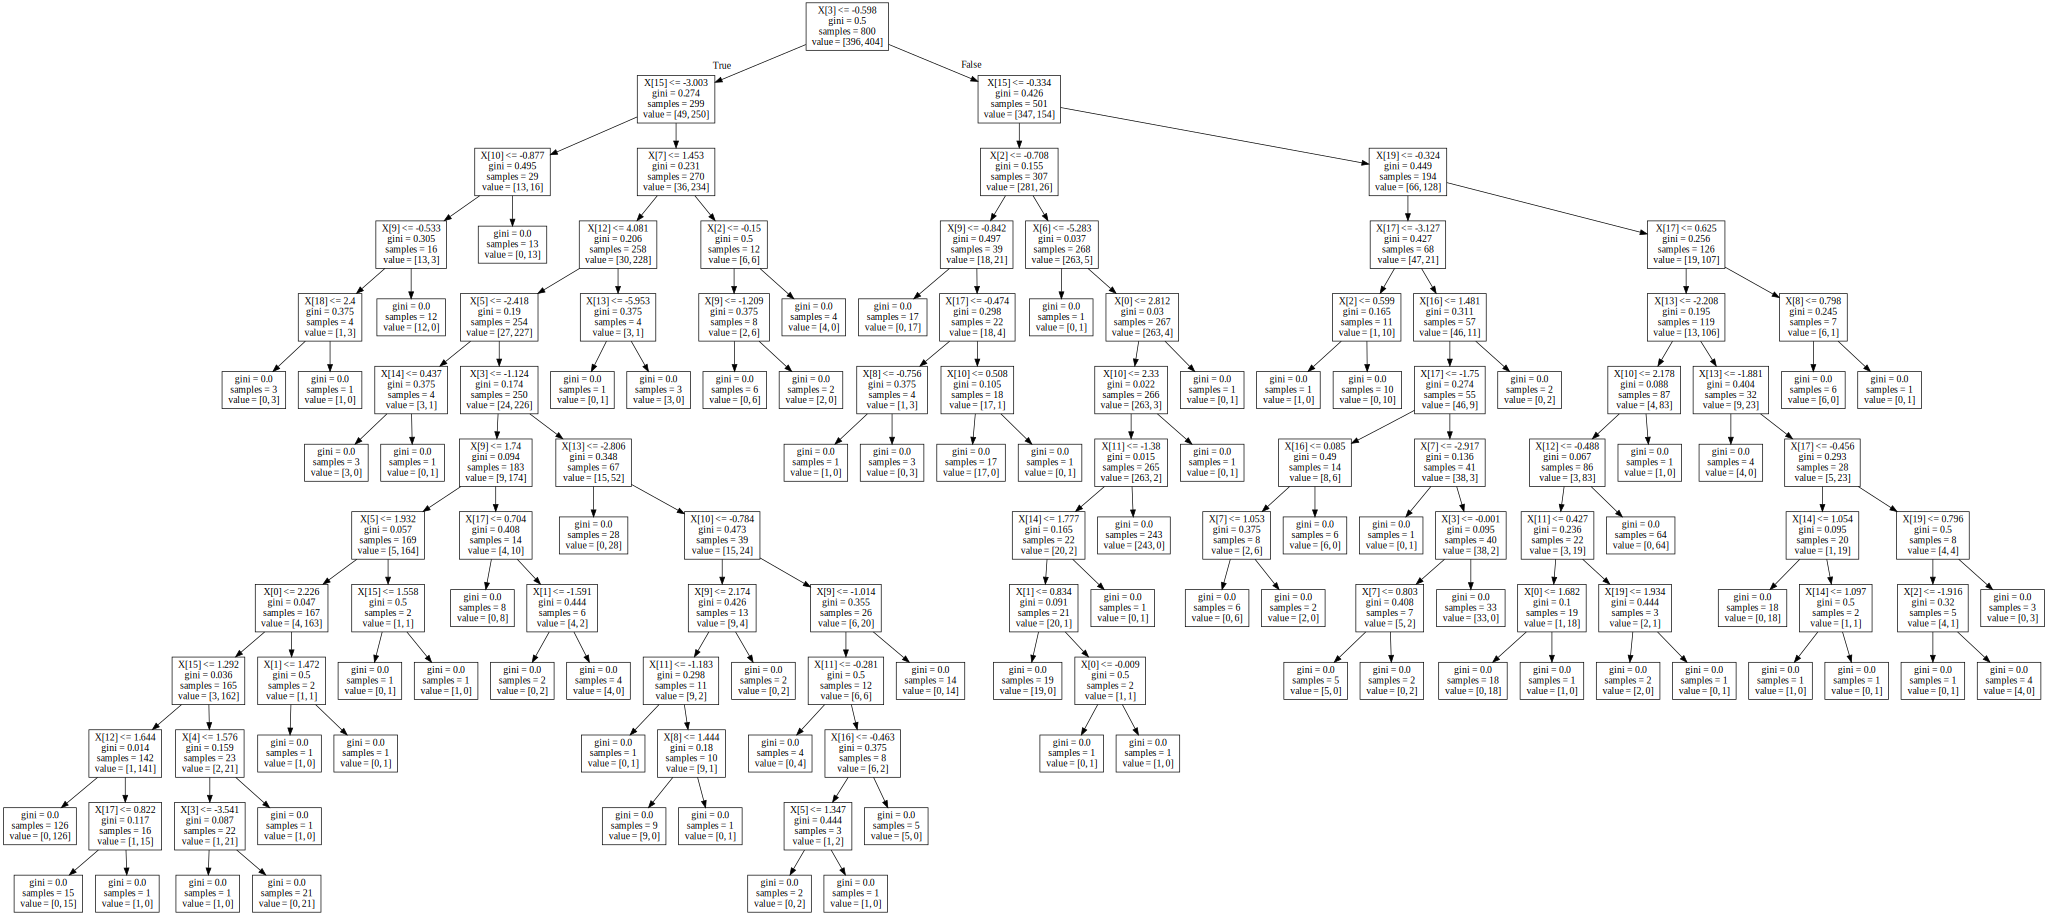

In [12]:
dot_data = export_graphviz(decision_tree, 
                           out_file=None)

graph = graphviz.Source(dot_data)  

graph 

### AdaBoost 
- AdaBoost classifier running on 1000 iterations (1000 trees created). 

- Also we are growing decision node up to first split (they are called decision stumps). 

- We are also going to use SAMME algorithm which is inteneded to work with discrete data (output from base_estimator is 0 or 1)

In [9]:
adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    algorithm='SAMME',
    n_estimators=1000,
    random_state=seed)

# train classifier
adaboost.fit(X_train, y_train)

# calculate predictions
adaboost_y_pred = adaboost.predict(X_test)
adaboost_y_pred_prob = adaboost.predict_proba(X_test)

# evaluate
adaboost_accuracy = accuracy_score(y_test, adaboost_y_pred)
adaboost_logloss = log_loss(y_test, adaboost_y_pred_prob)

print("== AdaBoost ==")
print("Accuracy: {0:.2f}".format(adaboost_accuracy))
print("Log loss: {0:.2f}".format(adaboost_logloss))

== AdaBoost ==
Accuracy: 0.84
Log loss: 0.68


- The log-loss metrics is much lower than in single decision tree (mainly to the fact that now we obtain probabilities output). 

- The accuracy is the same, but notice that the structure of the tree is much simpler. We are creating 1000 decision tree stumps.

Also here a quick peek into predicted values show that now 4 out of 5 first test instances are classified correctly.

In [14]:
print('True labels:')
print(y_test[:5,])
print('\nPredicted labels:')
print(adaboost_y_pred[:5,])
print('\nPredicted probabilities:')
print(adaboost_y_pred_prob[:5,])

True labels:
[1 1 0 0 0]

Predicted labels:
[1 0 0 0 0]

Predicted probabilities:
[[0.48396329 0.51603671]
 [0.49868559 0.50131441]
 [0.49892766 0.50107234]
 [0.50151698 0.49848302]
 [0.50566436 0.49433564]]


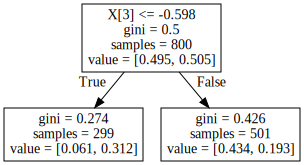

In [15]:
ada_t1 = adaboost.estimators_[0]
dot_data = export_graphviz(ada_t1, 
                           out_file=None)

graph = graphviz.Source(dot_data)  

graph 

What's it's error and contribution into final ensemble

In [16]:
print("Error: {0:.2f}".format(adaboost.estimator_errors_[0]))
print("Tree importance: {0:.2f}".format(adaboost.estimator_weights_[0]))

Error: 0.25
Tree importance: 1.08


### Gradient Boosted Trees
gradient boosted tree consiting of 1000 trees where each successive one will be created with gradient optimization. 

Again we are going to leave most parameters with their default values, specifiy only maximum depth of the tree to 1 (again decision stumps), and setting warm start for more intelligent computations.

In [10]:
gbc = GradientBoostingClassifier(
    max_depth=1,
    n_estimators=1000,
    warm_start=True,
    random_state=seed)
gbc.fit(X_train, y_train)

# make predictions
gbc_y_pred = gbc.predict(X_test)
gbc_y_pred_prob = gbc.predict_proba(X_test)

# calculate log loss
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_logloss = log_loss(y_test, gbc_y_pred_prob)

print("== Gradient Boosting ==")
print("Accuracy: {0:.2f}".format(gbc_accuracy))
print("Log loss: {0:.2f}".format(gbc_logloss))

== Gradient Boosting ==
Accuracy: 0.84
Log loss: 0.34


The obtained results are obviously the best of all presented algorithm. We have obtained most accurate algorithm giving more sensible predictions about class probabilities.

In [18]:
print('True labels:')
print(y_test[:5,])
print('\nPredicted labels:')
print(gbc_y_pred[:5,])
print('\nPredicted probabilities:')
print(gbc_y_pred_prob[:5,])

True labels:
[1 1 0 0 0]

Predicted labels:
[1 0 0 0 0]

Predicted probabilities:
[[0.12344095 0.87655905]
 [0.69217302 0.30782698]
 [0.83598136 0.16401864]
 [0.9159873  0.0840127 ]
 [0.99863653 0.00136347]]


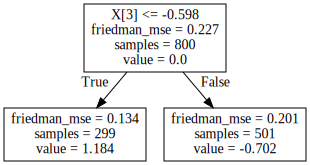

In [15]:
gbc_t1 = gbc.estimators_[2][0]
dot_data = export_graphviz(gbc_t1, 
                           out_file=None)

graph = graphviz.Source(dot_data)  

graph 

# XGB - Using standard interface

### Loading data

__Agaricus dataset __

- This data set records biological attributes of different _mushroom_ species, 
- the target is to predict whether it is poisonous

- This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom;

- It consist of 8124 instances, characterized by 22 attributes (both numeric and categorical). 
- The target class is either 0 or 1 which means binary classification problem.

** Important: XGBoost handles only numeric variables. **

- Categorical variables have been encoded, and all instances divided into train and test datasets. 

- Data needs to be stored in DMatrix object which is designed to handle sparse datasets. It can be populated in couple ways:
    using libsvm format txt file,
    using Numpy 2D array (most popular),
    using XGBoost binary buffer file

In [11]:
dtrain = xgb.DMatrix(r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.train')
dtest  = xgb.DMatrix(r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.test')

[15:07:14] 6513x127 matrix with 143286 entries loaded from E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.train
[15:07:14] 1611x127 matrix with 35442 entries loaded from E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.test


In [12]:
print("Train dataset contains {0} rows and {1} columns".format(dtrain.num_row(), dtrain.num_col()))
print("Test dataset contains {0} rows and {1} columns".format(dtest.num_row(), dtest.num_col()))

Train dataset contains 6513 rows and 127 columns
Test dataset contains 1611 rows and 127 columns


In [13]:
print("Train possible labels: ")
print(np.unique(dtrain.get_label()))

print("\nTest possible labels: ")
print(np.unique(dtest.get_label()))

Train possible labels: 
[0. 1.]

Test possible labels: 
[0. 1.]


#### Specify training parameters

- we are dealing with binary classification problem ('objective':'binary:logistic'),
- we want shallow single trees with no more than 2 levels ('max_depth':2),
- we don't any oupout ('silent':1),
- we want algorithm to learn fast and aggressively ('eta':1),
- we want to iterate only 5 rounds

In [14]:
params = {
    'objective':'binary:logistic',
    'max_depth':2,
    'silent':1,
    'eta':1
}

num_rounds = 5

#### Training classifier
To train the classifier we simply pass to it a training dataset, parameters list and information about number of iterations.

In [15]:
bst = xgb.train(params, dtrain, num_rounds)

In [16]:
# observe performance on test dataset using watchlist
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.042831	train-error:0.046522
[1]	test-error:0.021726	train-error:0.022263
[2]	test-error:0.006207	train-error:0.007063
[3]	test-error:0.018001	train-error:0.0152
[4]	test-error:0.006207	train-error:0.007063


#### Make predictions

In [17]:
preds_prob = bst.predict(dtest)
preds_prob

array([0.08073306, 0.92217326, 0.08073306, ..., 0.98059034, 0.01182149,
       0.98059034], dtype=float32)

In [18]:
# Calculate simple accuracy metric to verify the results.

labels = dtest.get_label()
preds = preds_prob > 0.5 # threshold
correct = 0

for i in range(len(preds)):
    if (labels[i] == preds[i]):
        correct += 1

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-correct/len(preds)))

Predicted correctly: 1601/1611
Error: 0.0062


# XGB - Using Scikit-learn Interface

### Loading data
- The scikit-learn package provides a convenient function load_svmlight capable of reading many libsvm files at once and storing them as Scipy's sparse matrices.

In [19]:
X_train, y_train, X_test, y_test = load_svmlight_files((r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.train', 
                                                        r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.test'))

In [20]:
print("Train dataset contains {0} rows and {1} columns".format(X_train.shape[0], X_train.shape[1]))
print("Test dataset contains {0} rows and {1} columns".format(X_test.shape[0], X_test.shape[1]))

Train dataset contains 6513 rows and 126 columns
Test dataset contains 1611 rows and 126 columns


In [21]:
print("Train possible labels: ")
print(np.unique(y_train))

print("\nTest possible labels: ")
print(np.unique(y_test))

Train possible labels: 
[0. 1.]

Test possible labels: 
[0. 1.]


### Specify training parameters

- we are dealing with binary classification problem ('objective':'binary:logistic'),
- we want shallow single trees with no more than 2 levels ('max_depth':2),
- we don't any oupout ('silent':1),
- we want algorithm to learn fast and aggressively ('learning_rate':1), (in naive named eta)
- we want to iterate only 5 rounds (n_estimators)

In [24]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 5
}

### Training classifier

In [25]:
bst = XGBClassifier(**params).fit(X_train, y_train)

XGBoostError: Invalid Parameter format for silent expect boolean but value='1.0'

### Make predictions

In [32]:
preds = bst.predict(X_test)
preds

array([0., 1., 0., ..., 1., 0., 1.])

In [33]:
correct = 0

for i in range(len(preds)):
    if (y_test[i] == preds[i]):
        correct += 1
        
acc = accuracy_score(y_test, preds)

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-acc))

Predicted correctly: 1601/1611
Error: 0.0062


# XGB - Spotting Most Important Features

- the relative importance of features in the dataset. Using this knowledge will help you to figure out what is driving the splits most for the trees and where we may be able to make some improvements in feature engineering if possible.

In [26]:
# laod data
dtrain = xgb.DMatrix(r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.train')
dtest  = xgb.DMatrix(r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.test')

[15:09:21] 6513x127 matrix with 143286 entries loaded from E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.train
[15:09:21] 1611x127 matrix with 35442 entries loaded from E:\MYLEARN\2-ANALYTICS-DataScience\datasets\agaricus.txt.test


###  Specify training parameters - 

we are going to use 5 stump decision trees with average learning rate.

In [27]:
# specify training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

In [28]:
# Train the model. In the same time specify watchlist to observe it's performance on the test set.
# see how does it perform
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.11049	train-error:0.113926
[1]	test-error:0.11049	train-error:0.113926
[2]	test-error:0.03352	train-error:0.030401
[3]	test-error:0.027312	train-error:0.021495
[4]	test-error:0.031037	train-error:0.025487


### Representation of a tree
While building a tree is divided recursively several times (in this example only once) - this operation is called split. To perform a split the algorithm must figure out which is the best (one) feature to use.

After that, at the bottom of the we get groups of observations packed in the leaves.

In the final model, these leafs are supposed to be as pure as possible for each tree, meaning in our case that each leaf should be made of one label class.

Not all splits are equally important. Basically the first split of a tree will have more impact on the purity that, for instance, the deepest split. Intuitively, we understand that the first split makes most of the work, and the following splits focus on smaller parts of the dataset which have been missclassified by the first tree.

In the same way, in Boosting we try to optimize the missclassification at each round (it is called the loss). So the first tree will do the big work and the following trees will focus on the remaining, on the parts not correctly learned by the previous trees.

The improvement brought by each split can be measured, it is the gain.

### Plotting

See which feature provided the most gain:

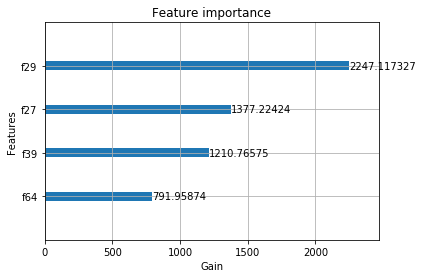

In [29]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain');

In [38]:
# plot feature importance
# xgb.plot_importance(bst)

# XGB - Bias/variance trade-off

** Bias and variance **

There are 2 general types of errors made by classifiers - 

- bias and variance errors.

    - Bias error is the overall difference between expected predictions made by the model and true values.

    - Variance error describes how much predictions for the given point vary. (across the runs)

The desired state is when both errors are as low as possible. 

Imagine that the center of the target is the perfect model. We are iteratively repeating our experiment, recreating model and using it on the same data points.

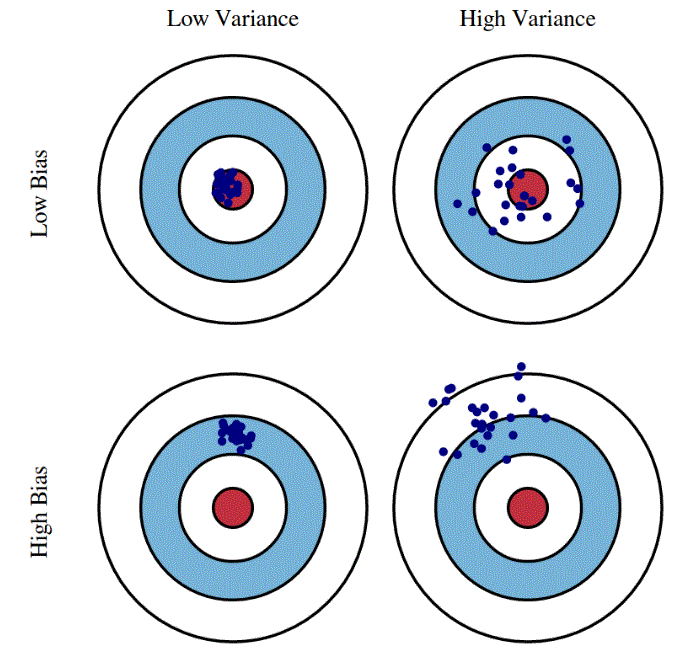




### Underfitting and overfitting
Knowing the errors introduced with bias and variance we can proceed to how these relate to training the model. 
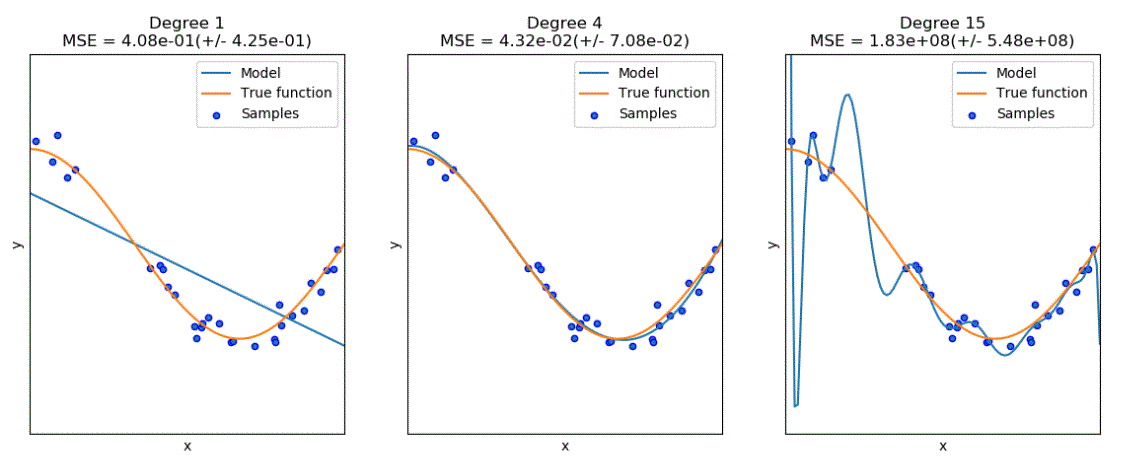

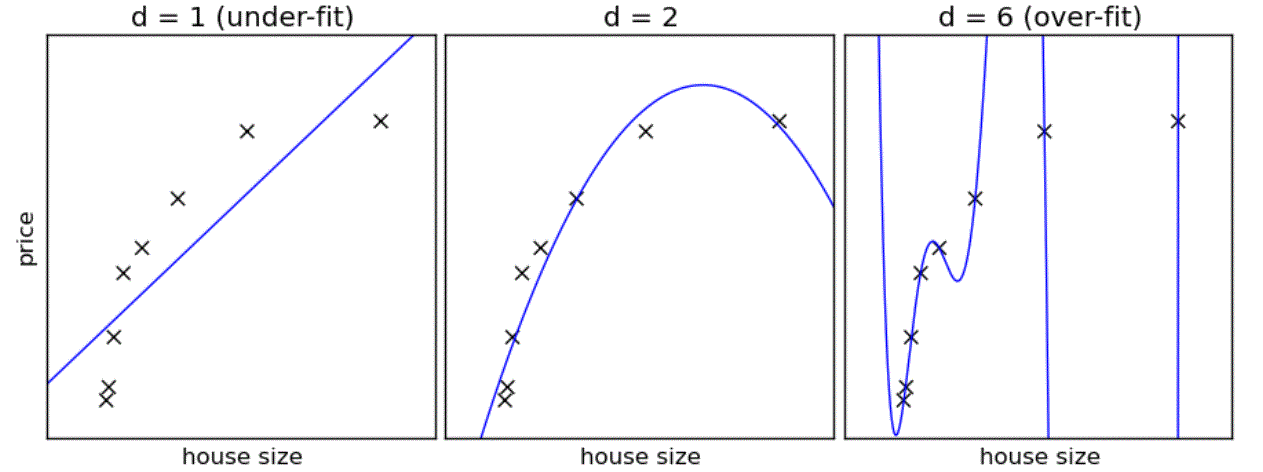


This simple example tries to fit a polynomial regression to predict future price. It's obious to see that for $d=1$ the model is too simple (underfits the data), and for $d=6$ is just the opposite (overfitting).

    For underfitting we say that model suffers from high bias (too simple) (low variance)
    For overfitting we say that model suffers from high variance (over-complicated, unstable) (low bias)

### How to detect it
To quantify the effects described we are going to train the model couple times for choosing different parameters value. Let's consider that we would like to find a optimal number of trees - we don't want the model to be very simple, but we also don't want to over-complicate it.

The plan is as follows, we will:

    generate complicated binary classification dataset,
    use Scikit-learn wrapper,
    train the model for different values of trees (n_estimators)) using stratified 10-fold CV,
    plot train/test errors

In [39]:
# Now generate artificial dataset
X, y = make_classification(n_samples=1000, 
                           n_features=20, 
                           n_informative=8, 
                           n_redundant=3, 
                           n_repeated=2, 
                           random_state=seed)

In [40]:
# k fold with shuffle
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [41]:
# set params
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1.0
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

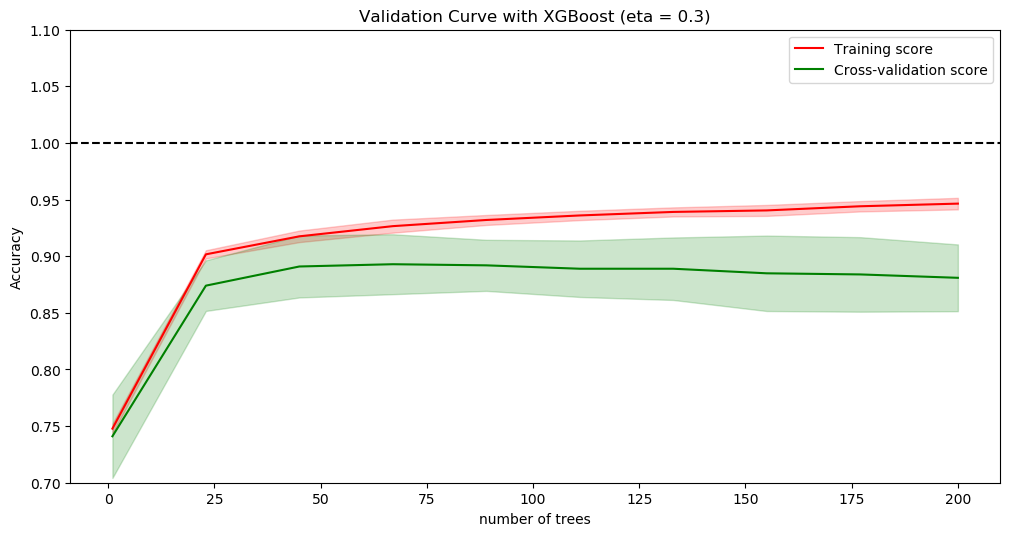

Best cross-validation result (0.89) obtained for 67 trees


In [42]:
# Show the validation curve plot
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)

test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(12, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

Looking at the plot we can draw the following conclusions:

- training score keeps growing while adding new trees, but from a certain point CV score is fixed
- variance is lowest, and bias is high for less than 25 trees,
- from about 25 trees, the variance is getting higher and while the CV score bias is holding steady (there is no point for adding extra trees / complexity)

we can see that the model is quite stable keeping variance fixed when increasing it's complexity

** We can assume that the trade-off for our model will be met at n_estimators = 50. The variance is still to big.**

### What we can do?

** (1) Dealing with high variance **

If model is too complex try:

    - using less features (ie. feature selection),
    - using more training samples (ie. artificially generated),
    - increasing regularization (add penalties for extra complexity)
    
    In XGBoost you can try to:

    - reduce depth of each tree (max_depth),
    - increase min_child_weight parameter,
    - increase gamma parameter,
    - add more randomness using subsample, colsample_bytree parameters,
    - increase lambda and alpha regularization parameters (smaller coeffcients)
    
** (2) Dealing with high bias **

If model is too simple:

    - add more features (ie. better feature engineering),
    - more sophisticated model
    - decrease regularization
    
    In XGBoost you can do it by:

    - increase depth of each tree (max_depth),
    - decrease min_child_weight parameter,
    - decrease gamma parameter,
    - decrease lambda and alpha regularization parameters (higher coefficients)

In [43]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 2,          # changed
    'learning_rate': 0.3,
    'silent': 1.0,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7         # added
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

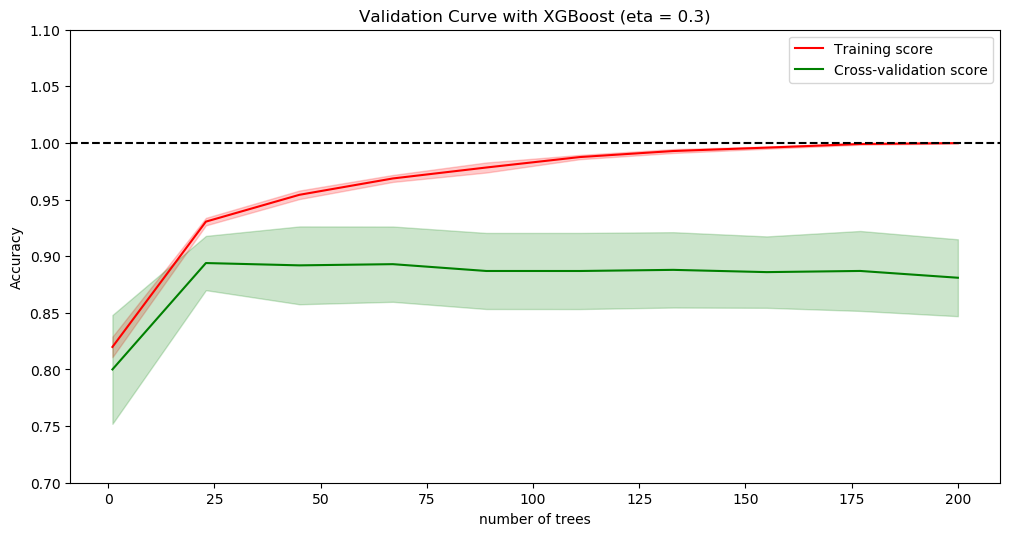

Best cross-validation result (0.89) obtained for 23 trees


In [44]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(12, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

# Hyper-parameter tuning

As you know there are plenty of tunable parameters. Each one results in different output. The question is which combination results in best output.

In [45]:
# Generate artificial dataset:
X, y = make_classification(n_samples=1000, 
                           n_features=20, 
                           n_informative=8, 
                           n_redundant=3, 
                           n_repeated=2, 
                           random_state=seed)

In [46]:
# Define cross-validation strategy for testing.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

### Grid-Search
In grid-search we start by defining a dictionary holding possible parameter values we want to test. All combinations will be evaluted.

In [47]:
params_grid = {
    'max_depth':     [1, 2, 3],
    'n_estimators':  [5, 10, 25, 50],
    'learning_rate': np.linspace(1e-16, 1, 3)
}

In [48]:
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

In [49]:
# Create a GridSearchCV estimator.
bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_grid=params_grid,
    cv=cv,
    scoring='accuracy'
)

Before running the calculations notice that $3*4*3*10=360$ models will be created to test all combinations. 

In [50]:
bst_grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=104, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=104, silent=1,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3], 'n_estimators': [5, 10, 25, 50], 'learning_rate': array([1.e-16, 5.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [114]:
print("Best accuracy obtained: {0}".format(bst_grid.best_score_))
print("Parameters:")
for key, value in bst_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: 0.905
Parameters:
	learning_rate: 0.5
	max_depth: 2
	n_estimators: 25


# Deal with missing values

- Missing value is commonly seen in real-world data sets. Handling missing values has no rule to apply to all cases, since there could be various reasons for the values to be missing.
- Two approaches - native interface, and Sklearn wrapper 

### Prepare data

In [115]:
# reproducibility
seed = 123

In [116]:
# create valid dataset
np.random.seed(seed)

data_v = np.random.rand(10, 5) # 10 entities, each contains 5 features
data_v

array([[0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897],
       [0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752],
       [0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426],
       [0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759],
       [0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338],
       [0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612],
       [0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029],
       [0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668],
       [0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916],
       [0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]])

In [117]:
# add some missing values
data_m = np.copy(data_v)

data_m[2, 3] = np.nan
data_m[0, 1] = np.nan
data_m[0, 2] = np.nan
data_m[1, 0] = np.nan
data_m[4, 4] = np.nan
data_m[7, 2] = np.nan
data_m[9, 1] = np.nan

data_m

array([[0.69646919,        nan,        nan, 0.55131477, 0.71946897],
       [       nan, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752],
       [0.34317802, 0.72904971, 0.43857224,        nan, 0.39804426],
       [0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759],
       [0.63440096, 0.84943179, 0.72445532, 0.61102351,        nan],
       [0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612],
       [0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029],
       [0.31226122, 0.42635131,        nan, 0.94416002, 0.50183668],
       [0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916],
       [0.25045537,        nan, 0.98555979, 0.51948512, 0.61289453]])

Also generate target variables. Each sample will be assigned to one of two classes - so we are dealing with binary classification problem

In [118]:
np.random.seed(seed)

label = np.random.randint(2, size=10) # binary target
label

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0])

### missing value - using Native interface
In this case we will check how does the native interface handles missing data. Begin with specifing default parameters.

In [136]:
# specify general training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

In [137]:
dtrain_v = xgb.DMatrix(data_v, label=label)

In [138]:
xgb.cv(params, dtrain_v, num_rounds, seed=seed)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.305556,0.274986,0.301587,0.118783
1,0.305556,0.274986,0.301587,0.118783
2,0.305556,0.274986,0.301587,0.118783
3,0.305556,0.274986,0.301587,0.118783
4,0.305556,0.274986,0.301587,0.118783


When creating DMatrix holding missing values we have to explicitly tell what denotes that it's missing. Sometimes it might be 0, 999 or others. In our case it's Numpy's NAN. Add missing argument to DMatrix constructor to handle it.

In [139]:
dtrain_m = xgb.DMatrix(data_m, label=label, missing=np.nan)

In [140]:
xgb.cv(params, dtrain_m, num_rounds, seed=seed)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.305556,0.274986,0.301587,0.118783
1,0.305556,0.274986,0.301587,0.118783
2,0.305556,0.274986,0.301587,0.118783
3,0.305556,0.274986,0.301587,0.118783
4,0.305556,0.274986,0.301587,0.118783


### missing value - using Sklearn

In [141]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.5,
    'silent': 1.0,
    'n_estimators': 5
}

In [142]:
clf = XGBClassifier(**params)
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=1.0, subsample=1)

In [143]:
cross_val_score(clf, data_v, label, cv=2, scoring='accuracy')

array([0.66666667, 0.75      ])

In [144]:
cross_val_score(clf, data_m, label, cv=2, scoring='accuracy')

array([0.66666667, 0.75      ])

Both methods works with missing datasets. The Sklearn package by default handles data with np.nan as missing

# Handle Imbalanced Dataset

There are plenty of examples in real-world problems that deals with imbalanced target classes. 

Imagine medical data where there are only a few positive instances out of thousands of negative (normal) ones. (God's mercy)

Another example might be analyzing fraud transaction, in which the actual frauds represent only a fraction of all available data.

> Imbalanced data refers to a classification problems where the classes are not equally distributed.

** common tactics when approaching imbalanced datasets: **

    - collect more data,
    - use better evaluation metric (that notices mistakes - ie. AUC, F1, Kappa, ...),
    - try oversampling minority class or undersampling majority class,
    - generate artificial samples of minority class (ie. SMOTE algorithm)
    
In XGBoost we can try to:

    - make sure that parameter min_child_weight is small (because leaf nodes can have smaller size groups), it is set to min_child_weight=1 by default,
    - assign more weights to specific samples while initalizing DMatrix,
    - control the balance of positive and negative weights using set_pos_weight parameter,
    - use AUC for evaluation

In [145]:
# reproducibility
seed = 123

In [148]:
X, y = make_classification(
                n_samples=200,
                n_features=5,
                n_informative=3,
                n_classes=2,
                weights=[.9, .1],
                shuffle=True,
                random_state=seed
)

In [149]:
print('There are {} positive instances.'.format(y.sum()))

There are 20 positive instances.


Divide created data into train and test. Remember so that both datasets should be similiar in terms of distribution, so they need stratification.

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    stratify=y, 
                                                    random_state=seed)

In [152]:
print('Total number of postivie train instances: {}'.format(y_train.sum()))
print('Total number of positive test instances: {}'.format(y_test.sum()))

Total number of postivie train instances: 13
Total number of positive test instances: 7


### Baseline model
In this approach try to completely ignore the fact that classed are imbalanced and see how it will perform. Create DMatrix for train and test data.


In [153]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test)

Assume that we will create 15 decision tree stumps, solving binary classification problem, where each next one will be train very aggressively.


In [154]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':1
}

num_rounds = 15

In [155]:
# Train the booster and make predictions.
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [156]:
# confusion matrix looks like
pd.crosstab(
    pd.Series(y_test,       name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,58,1,59
1,5,2,7
All,63,3,66


In [157]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.67
Recall: 0.29


- Intuitively we know that the foucs should be on finding positive samples. First results are very promising (94% accuracy ), 

- but deeper analysis show that the results are biased towards majority class - we are very poor at predicting the actual label of positive instances. 

- That is called an __accuracy paradox.__

### Option 1 - Custom weights
Try to explicitly tell the algorithm what important using relative instance weights. 

Let's specify that positive instances have 5x more weight and add this information while creating DMatrix.


In [158]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

In [159]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights) # weights added
dtest = xgb.DMatrix(X_test)

In [160]:
# Train the classifier and get predictions (same as in baseline):
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')


In [162]:
# Inspect the confusion matrix, and obtained evaluation metrics:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,57,2,59
1,4,3,7
All,61,5,66


In [163]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.60
Recall: 0.43


we made a trade-off here. We are now able to better classify the minority class, but the overall accuracy and precision decreased. 

Test multiple weights combinations and see which one works best.

### option -2 - Use scale_pos_weight parameter

You can automate the process of assigning weights manually by calculating the proportion between negative and positive instances and setting it to scale_pos_weight parameter.

Let's reinitialize datasets.

In [164]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test)

In [166]:
# Calculate the ratio between both classes and assign it to a parameter.
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio
params

{'eta': 1,
 'max_depth': 1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 9.307692307692308,
 'silent': 1}

In [167]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,56,3,59
1,4,3,7
All,60,6,66


In [168]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.89
Precision: 0.50
Recall: 0.43


- scalling weight by using scale_pos_weights in this case gives better results that doing it manually. 



** END here **

According to __dataset description__, the first column represents the mushroom classification based on the two categories “edible” and “poisonous”. 

The other columns are:

1. cap-shape: bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s
2. cap-surface: fibrous=f, grooves=g, scaly=y, smooth=s
3. cap-color: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y
4. bruises: bruises=t, no=f
5. odor: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s
6. gill-attachment: attached=a, descending=d, free=f, notched=n
7. gill-spacing: close=c, crowded=w, distant=d
8. gill-size: broad=b, narrow=n
9. gill-color: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y
10. stalk-shape: enlarging=e, tapering=t
11. stalk-root: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
12. stalk-surface-above-ring: fibrous=f, scaly=y, silky=k, smooth=s
13. stalk-surface-below-ring: fibrous=f, scaly=y, silky=k, smooth=s
14. stalk-color-above-ring: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
15. stalk-color-below-ring: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
16. veil-type: partial=p, universal=u
17. veil-color: brown=n, orange=o, white=w, yellow=y
18. ring-number: none=n, one=o, two=t
19. ring-type: cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z
20. spore-print-color: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y
21. population: abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y
22. habitat: grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d

# load the mushroom data

In [9]:
dtrain = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
                     header=None)

In [13]:
feature_names = ["class",
                "cap_shape",
                "cap_surface",
                "cap_color",
                "bruises",
                "odor",
                "gill_attachment",
                "gill_spacing",
                "gill_size",
                "gill_color",
                "stalk_shape",
                "stalk_root",
                "stalk_surface_above_ring",
                "stalk_surface_below_ring",
                "stalk_color_above_ring",
                "stalk_color_below_ring",
                "veil_type",
                "veil_color",
                "ring_number",
                "ring_type",
                "spore_print_color",
                "population",
                "habitat"]

In [14]:
# rename columns
dtrain.columns = feature_names

In [17]:
print(dtrain.shape)
dtrain.head()

(8124, 23)


,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [1]:
location = r'E:\\MYLEARN\\2-ANALYTICS-DataScience\\datasets\\pima.csv'

In [21]:
# Loading dataset and view a few records.
df = pd.read_csv(location)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
X = df.drop(['Outcome'], axis=1)
y = df.Outcome

In [23]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33,
                                                    random_state=42) 

#### Train the XGBoost Model

In [24]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]


In [26]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 74.02%
